In [1]:
# Scientific
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt

# Machine learning
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction import DictVectorizer

# Other
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('C:/Users/user/Desktop/bank-full.csv')

In [3]:
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [11]:
data.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')

In [13]:
data.drop(['loan', 'default'], axis=1, inplace=True)

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   balance    45211 non-null  int64 
 5   housing    45211 non-null  object
 6   contact    45211 non-null  object
 7   day        45211 non-null  int64 
 8   month      45211 non-null  object
 9   duration   45211 non-null  int64 
 10  campaign   45211 non-null  int64 
 11  pdays      45211 non-null  int64 
 12  previous   45211 non-null  int64 
 13  poutcome   45211 non-null  object
 14  y          45211 non-null  object
dtypes: int64(7), object(8)
memory usage: 5.2+ MB


In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# First, let's separate features (X) and target (y)
X = data.drop('y', axis=1)  # All columns except 'y'
y = data['y']  # Target variable

# Handle categorical variables (object dtype columns)
categorical_columns = ['job', 'marital', 'education', 'housing', 'contact', 'month', 'poutcome']
le = LabelEncoder()

# Encode each categorical column
for col in categorical_columns:
    X[col] = le.fit_transform(X[col])

# Now split into train, validation, and test sets
# First split: 60% train, 40% temp
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=1)

# Second split: split temp into validation and test (20% each of original data)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=1)

# Print the shapes to verify
print("Data split sizes:")
print(f"Training set: {X_train.shape[0]} samples ({len(X_train)/len(X):.1%})")
print(f"Validation set: {X_val.shape[0]} samples ({len(X_val)/len(X):.1%})")
print(f"Test set: {X_test.shape[0]} samples ({len(X_test)/len(X):.1%})")

# Print feature names for reference
print("\nFeatures included:", X.columns.tolist())

Data split sizes:
Training set: 27126 samples (60.0%)
Validation set: 9042 samples (20.0%)
Test set: 9043 samples (20.0%)

Features included: ['age', 'job', 'marital', 'education', 'balance', 'housing', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome']


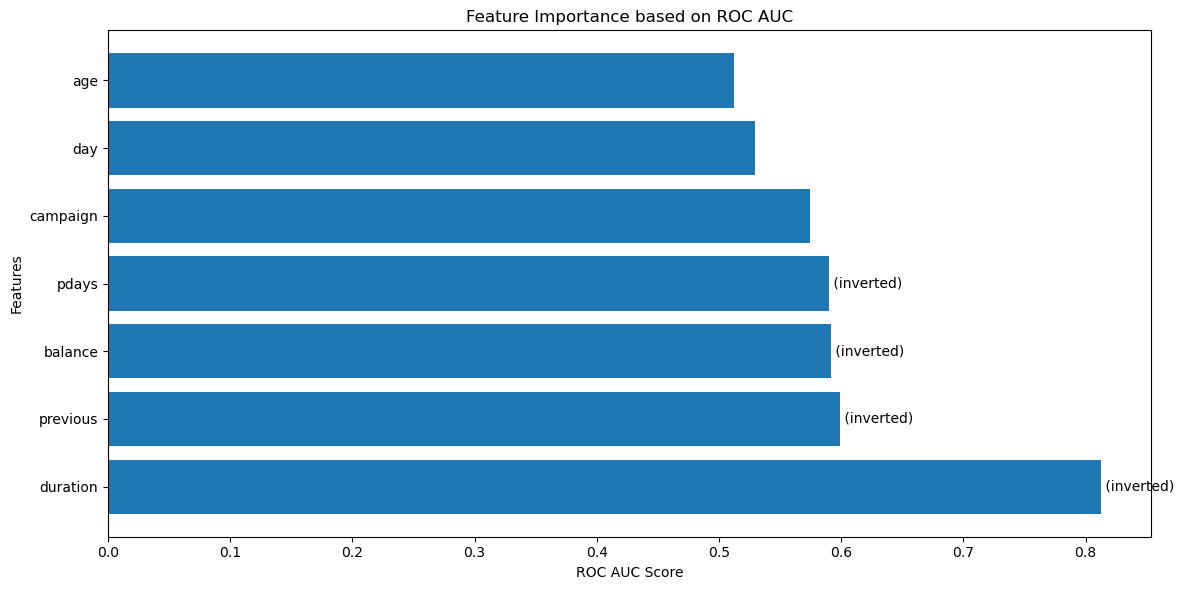


Feature Importance Details:
Feature          AUC Score Needs Inversion
--------------------------------------------------
duration            0.8129       Yes      
previous            0.5987       Yes      
balance             0.5917       Yes      
pdays               0.5898       Yes      
campaign            0.5742       No       
day                 0.5291       No       
age                 0.5125       No       

Recommended Feature Transformations:
To optimize all features, multiply these columns by the following coefficients:
balance: -1
duration: -1
pdays: -1
previous: -1


In [23]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

# Identify numerical columns
numerical_cols = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

# Convert target to binary numeric
# Assuming 'y' is binary categorical (e.g., 'yes'/'no')
y_train_numeric = (y_train == y_train.unique()[0]).astype(int)

# Calculate AUC for each numerical variable
auc_scores = {}
for col in numerical_cols:
    # Get raw AUC score
    auc = roc_auc_score(y_train_numeric, X_train[col])
    
    # If AUC < 0.5, calculate inverted AUC
    if auc < 0.5:
        auc = roc_auc_score(y_train_numeric, -X_train[col])
        auc_scores[col] = (auc, True)  # True indicates needs inversion
    else:
        auc_scores[col] = (auc, False)  # False indicates no inversion needed

# Sort features by AUC score
sorted_features = sorted(auc_scores.items(), key=lambda x: x[1][0], reverse=True)

# Create lists for plotting
features = [x[0] for x in sorted_features]
scores = [x[1][0] for x in sorted_features]
needs_inversion = [x[1][1] for x in sorted_features]

# Plot feature importance
plt.figure(figsize=(12, 6))
bars = plt.barh(features, scores)
plt.xlabel('ROC AUC Score')
plt.ylabel('Features')
plt.title('Feature Importance based on ROC AUC')

# Add markers for inverted features
for i, (needs_inv, bar) in enumerate(zip(needs_inversion, bars)):
    if needs_inv:
        plt.text(bar.get_width(), i, ' (inverted)', va='center')

plt.tight_layout()
plt.show()

# Print detailed results
print("\nFeature Importance Details:")
print("=" * 50)
print(f"{'Feature':<15} {'AUC Score':>10} {'Needs Inversion':<15}")
print("-" * 50)
for feature, (score, inv) in sorted_features:
    print(f"{feature:<15} {score:>10.4f} {'Yes' if inv else 'No':^15}")

# Create a dictionary of recommended feature transformations
feature_transformations = {
    col: (-1 if inv else 1) for col, (_, inv) in auc_scores.items()
}

print("\nRecommended Feature Transformations:")
print("=" * 50)
print("To optimize all features, multiply these columns by the following coefficients:")
for feature, coef in feature_transformations.items():
    if coef == -1:
        print(f"{feature}: {coef}")

In [25]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# Convert DataFrames to list of dictionaries
train_dict = X_train.to_dict(orient='records')
val_dict = X_val.to_dict(orient='records')

# Initialize and fit DictVectorizer
dv = DictVectorizer(sparse=False)
X_train_encoded = dv.fit_transform(train_dict)
X_val_encoded = dv.transform(val_dict)

# Convert target variables to numeric
# Assuming 'yes' is positive class - adjust if different
y_train_numeric = (y_train == 'yes').astype(int)
y_val_numeric = (y_val == 'yes').astype(int)

# Initialize and train logistic regression
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train_encoded, y_train_numeric)

# Make predictions on validation set
y_val_pred = model.predict_proba(X_val_encoded)[:, 1]

# Calculate AUC
auc_score = roc_auc_score(y_val_numeric, y_val_pred)
print(f"AUC on validation set: {auc_score:.3f}")

AUC on validation set: 0.865


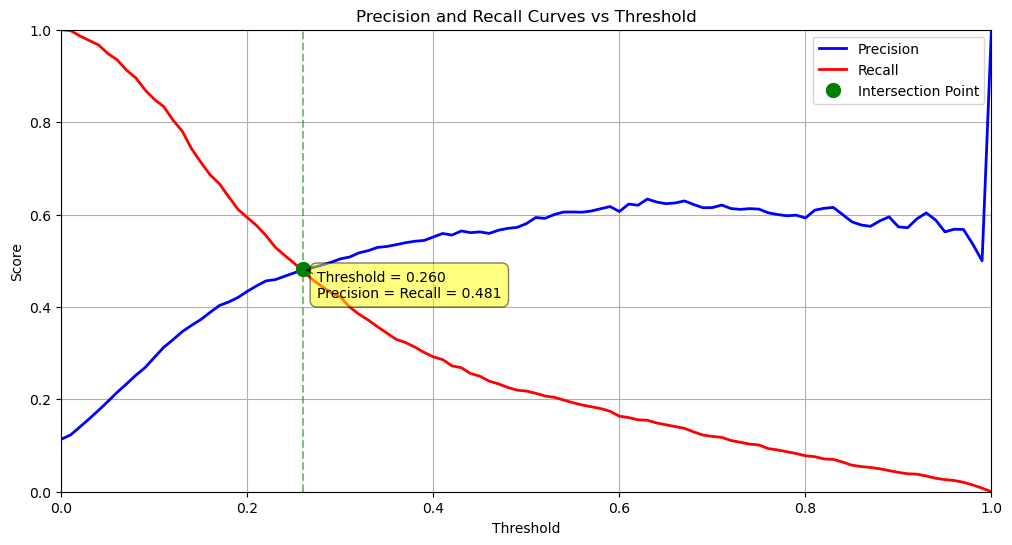


Intersection point details:
Threshold: 0.260
Precision: 0.481
Recall: 0.477


In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score

# Generate thresholds from 0.0 to 1.0 with step 0.01
thresholds = np.arange(0, 1.01, 0.01)

# Calculate precision and recall for each threshold
precisions = []
recalls = []

for threshold in thresholds:
    y_pred_binary = (y_val_pred >= threshold).astype(int)
    precision = precision_score(y_val_numeric, y_pred_binary, zero_division=1)
    recall = recall_score(y_val_numeric, y_pred_binary)
    precisions.append(precision)
    recalls.append(recall)

# Find intersection point
differences = np.abs(np.array(precisions) - np.array(recalls))
intersection_idx = np.argmin(differences)
threshold_intersection = thresholds[intersection_idx]

# Create the plot
plt.figure(figsize=(12, 6))

# Plot precision curve
plt.plot(thresholds, precisions, 'b-', linewidth=2, label='Precision')

# Plot recall curve
plt.plot(thresholds, recalls, 'r-', linewidth=2, label='Recall')

# Add intersection point
plt.plot(threshold_intersection, precisions[intersection_idx], 'go', markersize=10, label='Intersection Point')

# Add vertical line at intersection
plt.axvline(x=threshold_intersection, color='green', linestyle='--', alpha=0.5)

# Add annotations
plt.annotate(f'Threshold = {threshold_intersection:.3f}\nPrecision = Recall = {precisions[intersection_idx]:.3f}',
             xy=(threshold_intersection, precisions[intersection_idx]),
             xytext=(10, -20), textcoords='offset points',
             bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

# Customize the plot
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall Curves vs Threshold')
plt.grid(True)
plt.legend()
plt.ylim(0, 1)
plt.xlim(0, 1)

plt.show()

print(f"\nIntersection point details:")
print(f"Threshold: {threshold_intersection:.3f}")
print(f"Precision: {precisions[intersection_idx]:.3f}")
print(f"Recall: {recalls[intersection_idx]:.3f}")


Key Threshold Values:
Threshold     Precision        Recall         F1-Score    
------------------------------------------------------------
   0.20         0.434           0.593           0.501     
   0.30         0.504           0.421           0.459     
   0.40         0.551           0.292           0.382     
   0.50         0.580           0.218           0.317     
   0.60         0.606           0.163           0.257     
   0.70         0.615           0.120           0.200     
   0.80         0.593           0.078           0.138     


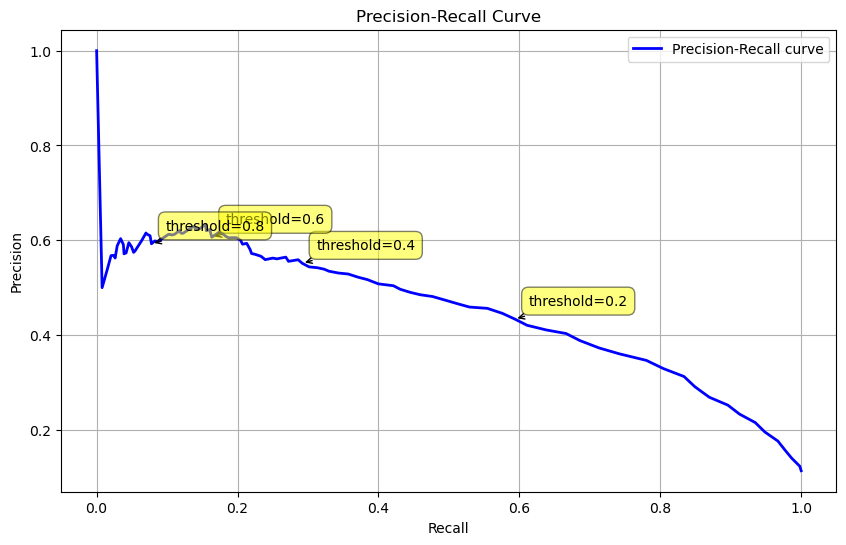

In [31]:
import numpy as np
from sklearn.metrics import precision_score, recall_score
import matplotlib.pyplot as plt

# Generate thresholds from 0.0 to 1.0 with step 0.01
thresholds = np.arange(0, 1.01, 0.01)

# Lists to store precision and recall for each threshold
precisions = []
recalls = []

# Calculate precision and recall for each threshold
for threshold in thresholds:
    # Convert probabilities to binary predictions based on threshold
    y_pred_binary = (y_val_pred >= threshold).astype(int)
    
    # Calculate precision and recall
    precision = precision_score(y_val_numeric, y_pred_binary, zero_division=1)
    recall = recall_score(y_val_numeric, y_pred_binary)
    
    precisions.append(precision)
    recalls.append(recall)

# Create the precision-recall curve plot
plt.figure(figsize=(10, 6))
plt.plot(recalls, precisions, 'b-', linewidth=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)

# Add threshold annotations at some key points
threshold_points = [0.2, 0.4, 0.6, 0.8]
for threshold in threshold_points:
    idx = int(threshold * 100)  # Convert threshold to index
    plt.annotate(f'threshold={threshold:.1f}', 
                xy=(recalls[idx], precisions[idx]),
                xytext=(10, 10), textcoords='offset points',
                bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

# Add a legend
plt.legend(loc='best')

# Display some key threshold values in a table
print("\nKey Threshold Values:")
print("=" * 60)
print(f"{'Threshold':^10} {'Precision':^15} {'Recall':^15} {'F1-Score':^15}")
print("-" * 60)
for threshold in [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]:
    idx = int(threshold * 100)
    f1 = 2 * (precisions[idx] * recalls[idx]) / (precisions[idx] + recalls[idx]) if (precisions[idx] + recalls[idx]) > 0 else 0
    print(f"{threshold:^10.2f} {precisions[idx]:^15.3f} {recalls[idx]:^15.3f} {f1:^15.3f}")

plt.show()

Maximum F1 Score: 0.503
Optimal Threshold: 0.210


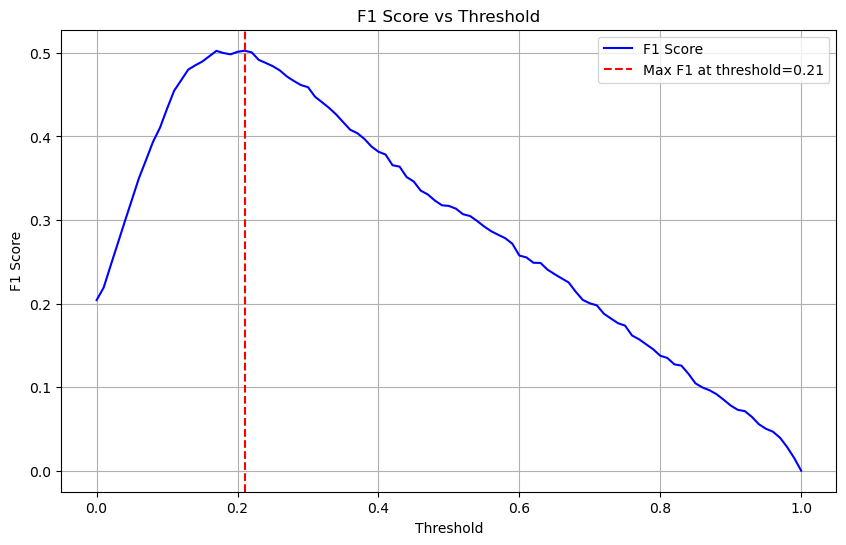

In [33]:
import numpy as np
from sklearn.metrics import f1_score

# Generate thresholds from 0.0 to 1.0 with step 0.01
thresholds = np.arange(0, 1.01, 0.01)

# Lists to store F1 scores
f1_scores = []

# Calculate F1 for each threshold
for threshold in thresholds:
    # Convert probabilities to binary predictions based on threshold
    y_pred_binary = (y_val_pred >= threshold).astype(int)
    
    # Calculate F1 score
    f1 = f1_score(y_val_numeric, y_pred_binary)
    f1_scores.append(f1)

# Find the threshold with maximum F1 score
max_f1_idx = np.argmax(f1_scores)
max_f1_threshold = thresholds[max_f1_idx]
max_f1_score = f1_scores[max_f1_idx]

print(f"Maximum F1 Score: {max_f1_score:.3f}")
print(f"Optimal Threshold: {max_f1_threshold:.3f}")

# Plot F1 scores
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, 'b-', label='F1 Score')
plt.axvline(x=max_f1_threshold, color='r', linestyle='--', label=f'Max F1 at threshold={max_f1_threshold:.2f}')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Threshold')
plt.grid(True)
plt.legend()
plt.show()

In [35]:
from sklearn.model_selection import KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# Initialize KFold
kf = KFold(n_splits=5, shuffle=True, random_state=1)

# Convert target to numeric
y_numeric = (data['y'] == 'yes').astype(int)

# Prepare features (all columns except target)
X = data.drop('y', axis=1)

# Lists to store AUC scores
auc_scores = []

# Iterate through folds
for fold, (train_idx, val_idx) in enumerate(kf.split(X), 1):
    # Split data
    X_train = X.iloc[train_idx]
    X_val = X.iloc[val_idx]
    y_train = y_numeric[train_idx]
    y_val = y_numeric[val_idx]
    
    # Convert to dictionary format for DictVectorizer
    train_dict = X_train.to_dict(orient='records')
    val_dict = X_val.to_dict(orient='records')
    
    # Initialize and fit DictVectorizer
    dv = DictVectorizer(sparse=False)
    X_train_encoded = dv.fit_transform(train_dict)
    X_val_encoded = dv.transform(val_dict)
    
    # Train model
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train_encoded, y_train)
    
    # Make predictions
    y_val_pred = model.predict_proba(X_val_encoded)[:, 1]
    
    # Calculate AUC
    auc = roc_auc_score(y_val, y_val_pred)
    auc_scores.append(auc)
    
    print(f'Fold {fold} - AUC: {auc:.3f}')

# Calculate mean and standard deviation of AUC scores
mean_auc = np.mean(auc_scores)
std_auc = np.std(auc_scores)

print('\nCross-validation results:')
print(f'Average AUC: {mean_auc:.3f} ± {std_auc:.3f}')

Fold 1 - AUC: 0.906
Fold 2 - AUC: 0.899
Fold 3 - AUC: 0.905
Fold 4 - AUC: 0.912
Fold 5 - AUC: 0.906

Cross-validation results:
Average AUC: 0.906 ± 0.004


In [37]:
std_auc = np.std(auc_scores)

In [39]:
std_auc

0.004246224260831405